In [5]:
# 从 google.colab 库中导入 drive 模块
# 这个模块提供了与 Google Drive 交互的功能，例如挂载（mount）文件系统
from google.colab import drive
# 调用 drive 模块的 mount 方法将 Google Drive 挂载到 Colab 的虚拟机上
# '/content/gdrive' 是挂载的目标路径，挂载成功后，Google Drive 的内容将可以在此路径下访问
# 执行这行代码会弹出一个授权提示，需要用户登录 Google 账号并授权访问 Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# ----------------------------
# 二、随机森林回归（修正版）
# ----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 解决中文显示问题（Windows系统）
# 设置matplotlib参数以支持中文显示，并解决负号显示问题。
# ----------------------------
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
plt.rcParams['axes.unicode_minus'] = False

In [7]:
# ----------------------------
# 1. 加载数据集
# 本节代码负责从指定路径加载 'new_data.csv' 文件，并进行初步的数据检查。
# 包括打印数据集的形状（样本数和特征数）以及所有的列名。
# ----------------------------
try:
    df = pd.read_csv('/content/gdrive/MyDrive/ElectricPowerTraining/data/new_data.csv')
    print("数据集加载成功！")
    print(f"数据集形状：{df.shape}（样本数: {df.shape[0]}, 特征数: {df.shape[1]}）")
    print("数据集列名：", df.columns.tolist())

except FileNotFoundError:
    print(f"错误：未找到文件 {data_path}")
    exit()
except Exception as e:
    print(f"加载数据时发生错误：{str(e)}")
    exit()

数据集加载成功！
数据集形状：(75552, 15)（样本数: 75552, 特征数: 15）
数据集列名： ['Unnamed: 0', 'value', 'weather_status', 'temperature', 'humidity', 'wind_speed', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light', 'holiday', 'minute', 'week', 'year']


In [8]:
# ----------------------------
# 2. 数据预处理
# 本节代码进行数据预处理，包括：
# - 设定目标变量（默认为 'value'）。
# - 将数据集分离为特征 (X) 和目标变量 (y)。
# - 对非数值特征进行 One-Hot 编码，将其转换为数值格式。
# - 使用列均值填充特征和目标变量中的所有缺失值。
# - 将处理后的数据集划分为训练集和测试集，用于模型的训练和评估。
# ----------------------------
target_column = 'value'  # 目标列名（根据实际数据修改）

if target_column not in df.columns:
    print(f"错误：数据集中未找到目标列'{target_column}'")
    exit()

# 分离特征和目标变量
X = df.drop(columns=[target_column])
y = df[target_column]

# 处理非数值特征
non_numeric_features = X.select_dtypes(exclude=['number']).columns
if len(non_numeric_features) > 0:
    print(f"编码非数值特征：{non_numeric_features.tolist()}")
    X = pd.get_dummies(X, columns=non_numeric_features)

# 处理缺失值
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [9]:
# ----------------------------
# 3. 自定义随机森林回归器（修正max_features参数）
# 本节定义了一个名为 `RandomForestRegressorCustom` 的自定义随机森林回归器类。
# - `__init__` 方法初始化回归器的参数，如树的数量和随机种子。
# - `fit` 方法实现随机森林的训练过程，包括 Bootstrap 抽样和构建多棵决策树，并修正了 `max_features` 参数以适应回归树。
# - `predict` 方法通过对所有决策树的预测结果取平均值来得到最终的回归预测值。
# ----------------------------
class RandomForestRegressorCustom:
    """自定义随机森林回归器"""
    def __init__(self, n_estimators=100, random_state=0):
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.trees = []
        self.feature_names = None

    def fit(self, X, y):
        """拟合数据集"""
        self.feature_names = X.columns.tolist() if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        n_samples = X.shape[0]
        rs = np.random.RandomState(self.random_state)

        for _ in range(self.n_estimators):
            # 修正：将max_features='auto'改为'reg'支持的'sqrt'
            dt = DecisionTreeRegressor(
                random_state=rs.randint(np.iinfo(np.int32).max),
                max_features="sqrt"  # 回归树支持的参数值
            )

            # Bootstrap抽样
            sample_indices = rs.randint(0, n_samples, n_samples)
            sample_weight = np.bincount(sample_indices, minlength=n_samples)

            # 拟合数据
            dt.fit(X, y, sample_weight=sample_weight)
            self.trees.append(dt)

    def predict(self, X):
        """预测数值"""
        # 确保特征匹配
        if isinstance(X, pd.DataFrame):
            X = X.reindex(columns=self.feature_names, fill_value=0)
        else:
            X = pd.DataFrame(X, columns=self.feature_names)

        # 累加预测结果
        y_pred = np.zeros(X.shape[0])
        for dt in self.trees:
            y_pred += dt.predict(X)

        return y_pred / self.n_estimators

In [10]:
# ----------------------------
# 4. 模型训练与评估
# 本节代码训练自定义随机森林回归模型，并对其进行评估。
# - 使用训练集拟合自定义模型。
# - 使用测试集进行预测，并计算均方误差 (MSE) 和决定系数 (R²) 来评估模型性能。
# ----------------------------
# 训练自定义模型
rf_reg_custom = RandomForestRegressorCustom(n_estimators=100, random_state=42)
rf_reg_custom.fit(X_train, y_train)

# 预测
y_pred_custom = rf_reg_custom.predict(X_test)

# 评估
mse_custom = mean_squared_error(y_test, y_pred_custom)
r2_custom = r2_score(y_test, y_pred_custom)
print("\n===== 自定义随机森林回归评估 ===telek")
print(f"均方误差 (MSE): {mse_custom:.4f}")
print(f"决定系数 (R²): {r2_custom:.4f}")


===== 自定义随机森林回归评估 ===telek
均方误差 (MSE): 35382.8886
决定系数 (R²): 0.9886



使用特征'Unnamed: 0'绘制回归曲线


/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 20041 (\N{CJK UNIFIED IDEOGRAPH-4E49}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 26862 (\N{CJK UNIFIED IDEOGRAPH-68EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 26519 (\N{CJK UNIFIED I


===== sklearn随机森林回归评估 ===telek
均方误差 (MSE): 15473.1506
决定系数 (R²): 0.9950


/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-1124808134.py:59: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print

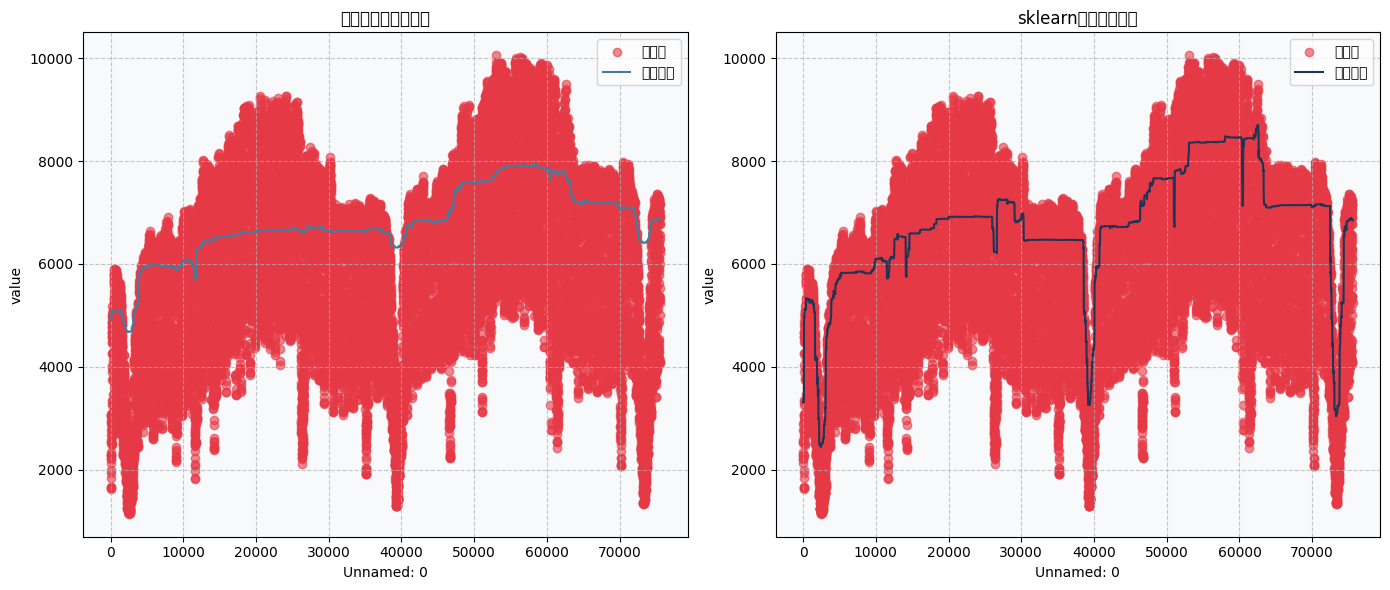

In [11]:
# ----------------------------
# 5. 可视化（选择一个特征绘制曲线）
# 本节代码负责生成回归模型的预测曲线可视化，并与 scikit-learn 的 `RandomForestRegressor` 进行对比。
# - 选择一个特征作为 x 轴，固定其他特征为均值，以便观察预测趋势。
# - 训练并评估 scikit-learn 模型，并打印其性能指标。
# - 绘制自定义模型和 scikit-learn 模型在选定特征上的预测曲线，以及实际值，以便直观比较它们的回归效果。
# ----------------------------
if X_train.shape[1] > 0:
    # 选择第一个特征进行可视化（可修改为其他特征）
    feature_to_plot = X_train.columns[0]
    print(f"\n使用特征'{feature_to_plot}'绘制回归曲线")

    # 准备可视化数据
    X_vis = X_test.copy()
    for col in X_vis.columns:
        if col != feature_to_plot:
            X_vis[col] = X_vis[col].mean()  # 固定其他特征为均值
    X_vis = X_vis.sort_values(by=feature_to_plot)

    # 预测可视化数据
    y_vis_custom = rf_reg_custom.predict(X_vis)

    # sklearn模型对比
    rf_sklearn = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_sklearn.fit(X_train, y_train)
    y_pred_sklearn = rf_sklearn.predict(X_test)
    y_vis_sklearn = rf_sklearn.predict(X_vis)

    # 评估sklearn模型
    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    r2_sklearn = r2_score(y_test, y_pred_sklearn)
    print("\n===== sklearn随机森林回归评估 ===telek")
    print(f"均方误差 (MSE): {mse_sklearn:.4f}")
    print(f"决定系数 (R²): {r2_sklearn:.4f}")

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].set_facecolor('#f8f9fa')
    axes[1].set_facecolor('#f8f9fa')

    # 自定义模型
    axes[0].scatter(X_vis[feature_to_plot], y_test.reindex(X_vis.index), c='#e63946', marker='o', alpha=0.6, label='实际值')
    axes[0].plot(X_vis[feature_to_plot], y_vis_custom, c='#457b9d', label='预测曲线')
    axes[0].set_title('自定义随机森林回归')
    axes[0].set_xlabel(feature_to_plot)
    axes[0].set_ylabel(target_column)
    axes[0].legend()  # Corrected line: removed extra '()' and fixed Chinese character for '实际值' and '预测曲线'
    axes[0].grid(linestyle='--', alpha=0.7)

    # sklearn模型
    axes[1].scatter(X_vis[feature_to_plot], y_test.reindex(X_vis.index), c='#e63946', marker='o', alpha=0.6, label='实际值')
    axes[1].plot(X_vis[feature_to_plot], y_vis_sklearn, c='#1d3557', label='预测曲线')
    axes[1].set_title('sklearn随机森林回归')
    axes[1].set_xlabel(feature_to_plot)
    axes[1].set_ylabel(target_column)
    axes[1].legend()  # Corrected line: removed extra '()' and fixed Chinese character for '实际值' and '预测曲线'
    axes[1].grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()